In [1]:
%matplotlib

Using matplotlib backend: agg


In [2]:
# dounload the dataset
%%bash
data_dir="./data"
dataset_name="hymenoptera_data"

if [ ! -d $data_dir ];then  # 文件夹不存在
  mkdir $data_dir
fi
cd $data_dir


if [ ! -d $dataset_name ];then
  wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
  unzip hymenoptera_data.zip
  rm hymenoptera_data.zip
  echo "complete to download the dataset"
else
  echo "You have downloaded the dataset"
fi
cd ..


You have downloaded the dataset


# 相关文章




https://cs231n.github.io/transfer-learning/


### 三个主要的迁移学习的情景

1. 卷积层固定的特征提取：仅仅是把最后的全连接层除去(this layer’s outputs are the 1000 class scores for a different task like ImageNet)，然后把剩下的全连接层当作一个新数据集的固定特征提取器。

2. 微调卷积网络：不仅仅替换全连接层，还继续训练神经网络。可以把前几层固定，调整后几层的参数。

3. 预训练模型：

### 什么时候使用fine-tune?

有两个重要考虑因素，新数据集的大小，与原数据集的相似性。下面讨论四种不同情况：

1. 新数据集很小并且与原数据相似：考虑只训练最后分类的全连接层，因为数据集很小，调整ConvNet可能会导致过拟合。

2. 新数据集很大并且与原数据集相似：微调整个网络。因为数据集很大，不用担心过拟合。

3. 新数据集很小并且与原数据不同：从网络较早的某个位置进行激活训练SVM分类器可能更好。

4. 新数据集很大，并且与原始数据集有很大不同：最好从头训练整个网络。但是，实际上，使用来自预训练模型的权重进行初始化通常仍然是有益的。


### 实际操作建议

1. 来自预训练模型的约束：其一，不能任意调整转化层。其二，由于参数共享，可以轻松使用该网络将不同空间大小的图像转化为相同的体积。

2. 学习率：学习率应该设置较小，因为我们认为预训练模型已经很接近真实模型了。

# 迁移计算机视觉学习
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#

In this tutorial, you will learn how to train a convolutional neural network for image classification using transfer learning. You can read more about the transfer learning at cs231n notes.

In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.

These two major transfer learning scenarios look as follows:

- Finetuning the convnet: Instead of random initializaion, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.
- ConvNet as fixed feature extractor: Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

In [3]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

# Hyper parameters
BATCH_SIZE = 4
NUM_WORK = 0
data_path = './data'
LR = 0.001
MOMENTUM = 0.9

plt.ion()  # interactive mode

np.random.seed(1)
torch.manual_seed(1)

## 导入数据

We will use torchvision and torch.utils.data packages for loading the data.

The problem we’re going to solve today is to train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.

In [4]:
# Data augmentation and normalization for training 
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # mean and std
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

}

data_dir = data_path + '/hymenoptera_data'
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'val']
}
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, 
                                  shuffle=True, num_workers=NUM_WORK)
    for x in ['train', 'val']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
len(dataloaders['train'].dataset)
print(dataset_sizes['train'])

244


## 可视化部分图片

Let’s visualize a few training images so as to understand the data augmentations.

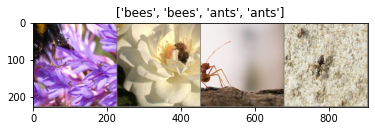

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
classes.data

tensor([1, 1, 0, 0])

## 模型训练相关函数

Now, let’s write a general function to train a model. Here, we will illustrate:

- Scheduling the learning rate
- Saving the best model

In the following, parameter scheduler is an LR scheduler object from ``torch.optim.lr_scheduler``.



### 模型训练函数

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epoch=25, 
                dataloaders=dataloaders, device = device):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch, num_epoch-1))
        print('-' * 10)
        
        # Each epoch has a train and vlidation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # set the mode to train
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameters gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # statistics
                running_loss += loss.item() * inputs.size(0) # 这里需要试一下
                running_corrects += torch.sum(preds == labels)
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.item() / len(dataloaders[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
                
    

### 可视化数据函数

Generic function to display predictions for a few images

In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                
                ax.set_title('predicted: {}, true name {}'.format(
                    class_names[preds[j]], class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## 微调卷积神经网络

Load a pretrained model and reset final fully connected layer.

In [10]:
model_ft = models.resnet18(pretrained=True)  # model fine-tune
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2
# Alternaticvely, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe taht all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=LR, momentum=MOMENTUM)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### 训练，评估

It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.

In [11]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler)

Epoch 0/24
----------
train Loss: 0.5957 Acc: 0.7008
val Loss: 0.5593 Acc: 0.7582

Epoch 1/24
----------
train Loss: 0.8028 Acc: 0.7213
val Loss: 0.4512 Acc: 0.8562

Epoch 2/24
----------
train Loss: 0.5685 Acc: 0.7992
val Loss: 0.5219 Acc: 0.7908

Epoch 3/24
----------
train Loss: 0.6280 Acc: 0.7623
val Loss: 0.3628 Acc: 0.8693

Epoch 4/24
----------
train Loss: 0.5643 Acc: 0.7828
val Loss: 0.3005 Acc: 0.8954

Epoch 5/24
----------
train Loss: 0.6172 Acc: 0.7582
val Loss: 0.2491 Acc: 0.9085

Epoch 6/24
----------
train Loss: 0.5505 Acc: 0.7664
val Loss: 0.4436 Acc: 0.8366

Epoch 7/24
----------
train Loss: 0.4780 Acc: 0.8443
val Loss: 0.2145 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3801 Acc: 0.8279
val Loss: 0.2233 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.2608 Acc: 0.9139
val Loss: 0.2556 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.3289 Acc: 0.8279
val Loss: 0.2094 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.2693 Acc: 0.8770
val Loss: 0.1993 Acc: 0.9346

Ep

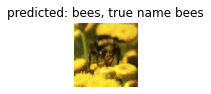

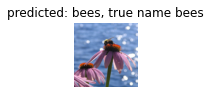

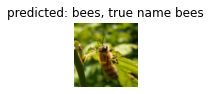

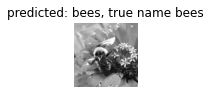

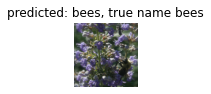

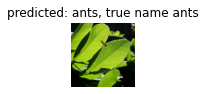

In [16]:
visualize_model(model_ft)

## 把卷积网络当成固定特征提取器

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.

In [13]:
model_conv = models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.require_grad = False

# Here the size of each output sample is set to 2
# Alternaticvely, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe the only parameters of final layer are being optimized as opposed to before
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=LR, momentum=MOMENTUM)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### 训练，评估

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.

In [14]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler)

Epoch 0/24
----------
train Loss: 0.5610 Acc: 0.7172
val Loss: 0.6075 Acc: 0.7059

Epoch 1/24
----------
train Loss: 0.5889 Acc: 0.7500
val Loss: 0.4774 Acc: 0.8039

Epoch 2/24
----------
train Loss: 0.4197 Acc: 0.7992
val Loss: 0.3032 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.4864 Acc: 0.7910
val Loss: 0.2156 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.4440 Acc: 0.8156
val Loss: 0.2106 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.4358 Acc: 0.8115
val Loss: 0.2426 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.4343 Acc: 0.8402
val Loss: 0.2084 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3538 Acc: 0.8279
val Loss: 0.1949 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3388 Acc: 0.8648
val Loss: 0.1947 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3749 Acc: 0.8279
val Loss: 0.2135 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.2585 Acc: 0.8975
val Loss: 0.2037 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.2920 Acc: 0.8689
val Loss: 0.2069 Acc: 0.9346

Ep

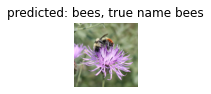

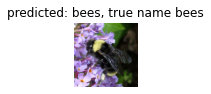

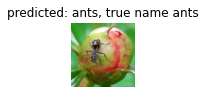

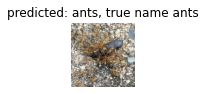

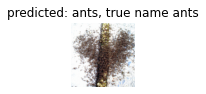

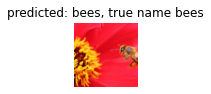

In [15]:
visualize_model(model_conv)

plt.ioff()
plt.show()